In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from Bandit import Bandit
import warnings
warnings.filterwarnings("ignore")
num_trials = 20000
bandit_rewards_list = [1,2,3,4]


In [53]:

class EpsilonGreedyBandit(Bandit):
    def __init__(self, reward):
        self.reward = reward
        self.reward_estimate = 0.0
        self.N = 0
        self.learning_process = []
        self.bandits = None
        self.epsilon = 1.0
        self.data = None

    def pull(self):
        return np.random.normal(self.reward, 1.0)

    def update(self, x):
        self.N += 1
        self.reward_estimate = ((self.N - 1) * self.reward_estimate + x) / self.N
        self.learning_process.append(self.reward_estimate)

    def __repr__(self):
        return f'A bandit with actual reward: {self.reward} and estimated reward {self.reward_estimate}'

    def plot1(self):
        if self.bandits is None:
            raise Exception('Run the experiment first')
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        plt.suptitle('The learning curves of all 4 bandits', size=15)
        for index, bandit in enumerate(self.bandits):
            x_index = 1 if index >= 2 else 0
            y_index = index % 2
            axs[x_index, y_index].plot(bandit.learning_process)
            axs[x_index, y_index].set_title(f'True reward: {bandit.reward}')
        plt.show()

    def experiment(self, bandit_rewards, num_trials, path_to_save='', to_save=False):
        if to_save:
            self.create_data()
        self.bandits = [EpsilonGreedyBandit(reward) for reward in bandit_rewards]
        self.rewards = np.zeros(num_trials)
        self.regret = []
        data_list = []  # List to store data
        for i in range(num_trials):
            if np.random.random() < self.epsilon:
                index = np.random.randint(len(self.bandits))
            else:
                index = np.argmax([b.reward_estimate for b in self.bandits])
            selected_bandit = self.bandits[index]
            x = selected_bandit.pull()
            if to_save:
                data_list.append({'Bandit': index, 'Reward': x, 'Algorithm': selected_bandit.__class__.__name__})
            self.rewards[i] = x
            self.regret.append(selected_bandit.reward - x)
            selected_bandit.update(x)
            self.update_epsilon(i, num_trials)
        if to_save:
            self.data = pd.DataFrame(data_list)  # Create the DataFrame from the list of data
            self.data.to_csv("/Users/user/Desktop/HWMARK/results.csv", index=False)
        self.report("/Users/user/Desktop/HWMARK/results.csv", to_save)
        return self.rewards

    def report(self, path_to_save, to_save=False):
        print(' ' * 45 + '\033[1m' + 'Report' + '\033[0m')
        if self.bandits is None:
            raise Exception('Run the experiment first')

        print('\n-= Part 1 =-')
        self.plot1()

        print('\n-= Part 2 =-')
        cumulative_rewards = np.cumsum(self.rewards)
        plt.plot(cumulative_rewards)
        plt.title('Plot of cumulative rewards\n', size=15)
        plt.show()

        cumulative_reward = cumulative_rewards[-1]
        print(f'The sum reward for the experiment is {cumulative_reward}')
        print(f'The cumulative reward for the experiment is {cumulative_rewards}')

        cumulative_regrets = np.cumsum(self.regret)
        cumulative_regret = cumulative_regrets[-1]
        print(f'\nThe sum of regret for the experiment is {cumulative_regret}')
        print(f'The cumulative regret for the experiment is {cumulative_regrets}')

    def create_data(self):
        self.data = None
        print('The data container is created.')

    def update_epsilon(self, current_trial, num_trials):
        self.epsilon = 1 - (current_trial / num_trials)


The data container is created.
                                             Report

-= Part 1 =-


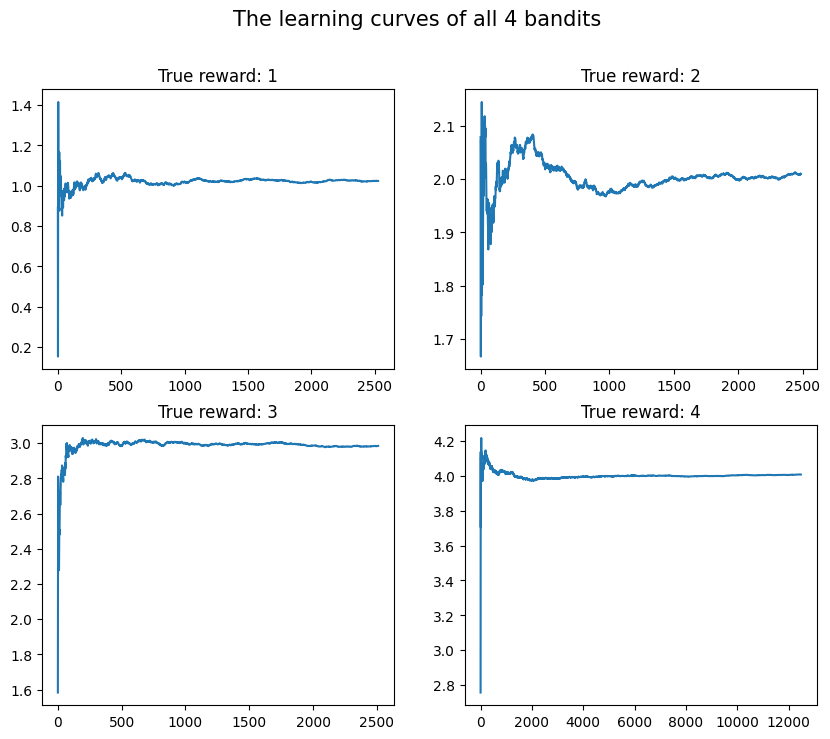


-= Part 2 =-


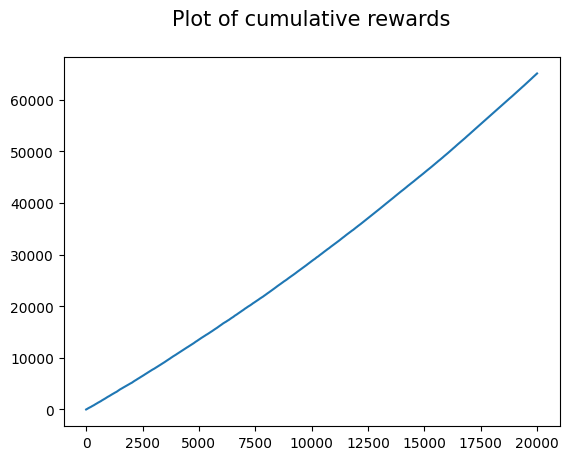

The sum reward for the experiment is 65074.523767786915
The cumulative reward for the experiment is [1.58361385e+00 3.66315568e+00 5.49905434e+00 ... 6.50668899e+04
 6.50710747e+04 6.50745238e+04]

The sum of regret for the experiment is -143.52376778695657
The cumulative regret for the experiment is [   1.41638615    1.33684432    1.50094566 ... -143.88993847 -144.07472575
 -143.52376779]


In [54]:
eps_rewards = EpsilonGreedyBandit(Bandit).experiment(bandit_rewards_list, num_trials, './data/EpsilonGreedy.csv', to_save=True)

In [51]:

class ThompsonSamplingBandit(Bandit):
    def __init__(self, reward):
        self.reward = reward
        self.m = 0.0
        self.lambda_ = 1.0
        self.tau = 1.0
        self.N = 0
        self.sum_x = 0.0
        self.learning_process = []
        self.bandits = None
        self.data = None

    def pull(self):
        return np.random.randn() / np.sqrt(self.tau) + self.reward

    def sample(self):
        return np.random.randn() / np.sqrt(self.lambda_) + self.m

    def update(self, x):
        self.lambda_ += self.tau
        self.sum_x += x
        self.m = (self.tau * self.sum_x) / self.lambda_
        self.learning_process.append(self.m)
        self.N += 1

    def __repr__(self):
        return f'A bandit with actual reward: {self.reward} and estimated reward {self.m}'

    def plot1(self):
        if self.bandits is None:
            raise Exception('Run the experiment first')
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        plt.suptitle('The learning curves of all 4 bandits', size=15)
        for index, bandit in enumerate(self.bandits):
            x_index = 1 if index >= 2 else 0
            y_index = index % 2
            axs[x_index, y_index].plot(bandit.learning_process)
            axs[x_index, y_index].set_title(f'True reward: {bandit.reward}')
        plt.show()

    def experiment(self, bandit_rewards, num_trials, path_to_save, to_save=False):
        if to_save:
            self.create_data()
        self.bandits = [ThompsonSamplingBandit(reward) for reward in bandit_rewards]
        self.rewards = np.zeros(num_trials)
        self.regret = []
        data_list = []
        for i in range(num_trials):
            index = np.argmax([b.sample() for b in self.bandits])
            selected_bandit = self.bandits[index]
            x = selected_bandit.pull()
            if to_save:
                data_list.append({'Bandit': index, 'Reward': x, 'Algorithm': selected_bandit.__class__.__name__})
            self.rewards[i] = x
            self.regret.append(selected_bandit.reward - x)
            selected_bandit.update(x)
        if to_save:
            self.data = pd.DataFrame(data_list)
            self.data.to_csv("/Users/user/Desktop/HWMARK/results1.csv", index=False)
        self.report("/Users/user/Desktop/HWMARK/results1.csv", to_save)
        return self.rewards

    def report(self, path_to_save, to_save=False):
        if self.bandits is None:
            raise Exception('Run the experiment first')
        print(' ' * 35 + '\033[1m' + 'Report' + '\033[0m')

        print('\n-= Part 1 =-')
        self.plot1()

        print('\n-= Part 2 =-')
        cumulative_rewards = np.cumsum(self.rewards)
        plt.plot(cumulative_rewards)
        plt.title('Plot of cumulative rewards\n', size=15)
        plt.show()

        if to_save:
            self.data.to_csv(path_to_save, index=False)

        cumulative_reward = cumulative_rewards[-1]
        print(f'The sum reward for the experiment is {cumulative_reward}')
        print(f'The cumulative reward for the experiment is {cumulative_rewards}')

        cumulative_regrets = np.cumsum(self.regret)
        cumulative_regret = cumulative_regrets[-1]
        print(f'\nThe sum of regret for the experiment is {cumulative_regret}')
        print(f'The cumulative regret for the experiment is {cumulative_regrets}')

    def create_data(self):
        self.data = None
        print('The data container is created.')


The data container is created.
                                   Report

-= Part 1 =-


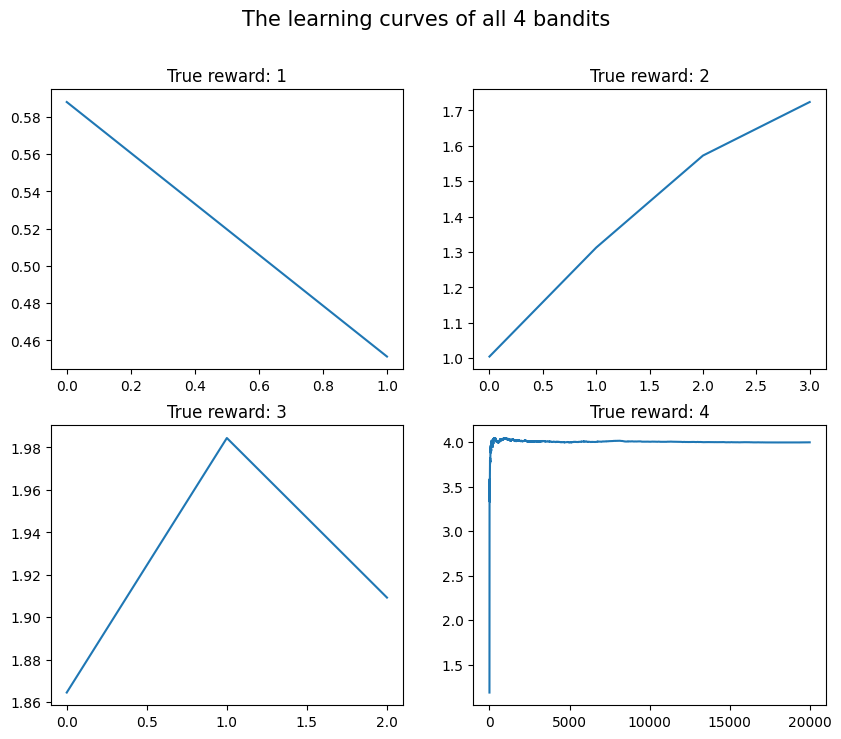


-= Part 2 =-


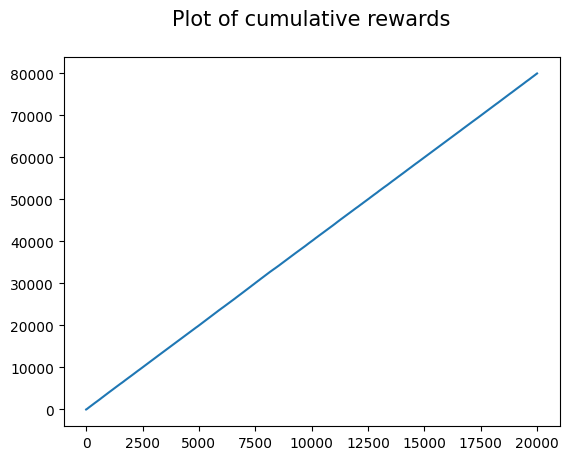

The sum reward for the experiment is 79956.70431633595
The cumulative reward for the experiment is [1.17585779e+00 3.18511930e+00 5.11303888e+00 ... 7.99472255e+04
 7.99524714e+04 7.99567043e+04]

The sum of regret for the experiment is 26.295683664210266
The cumulative regret for the experiment is [-0.17585779 -0.1851193  -0.11303888 ... 27.77454833 26.52864043
 26.29568366]


In [55]:
thompson_rewards = ThompsonSamplingBandit(Bandit).experiment(bandit_rewards_list, num_trials, './data/ThompsonSampling.csv', to_save=True)

In [49]:
def comparison(eps_reward, thompson_reward, num_trials):   
    """
    A function for comparing Epsilon Greedy with Thompson Sampling algorithms.
    
    Args:
    
        eps_reward (list): Epsilon rewards.
        thompson_reward(list): Thompson rewards.
        num_trails (int): The number of trials.
    
    """
    plt.plot(np.arange(num_trials), np.cumsum(eps_reward), label='Epsilon-Greedy')
    plt.plot(np.arange(num_trials), np.cumsum(thompson_reward), label='Thompson Sampling')
    plt.xlabel('#Trials')
    plt.ylabel('Estimated Reward')
    plt.title('Comparison of Epsilon-Greedy and Thompson Sampling')
    plt.legend()
    plt.show()

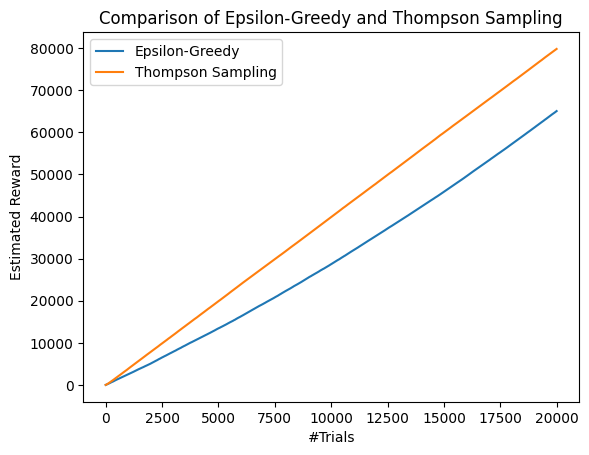

In [50]:
comparison(eps_rewards, thompson_rewards, num_trials)